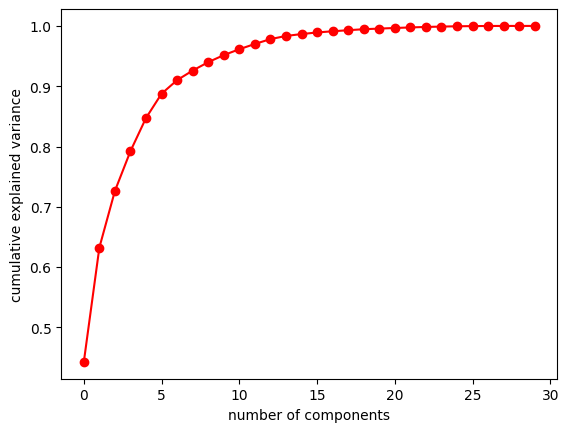

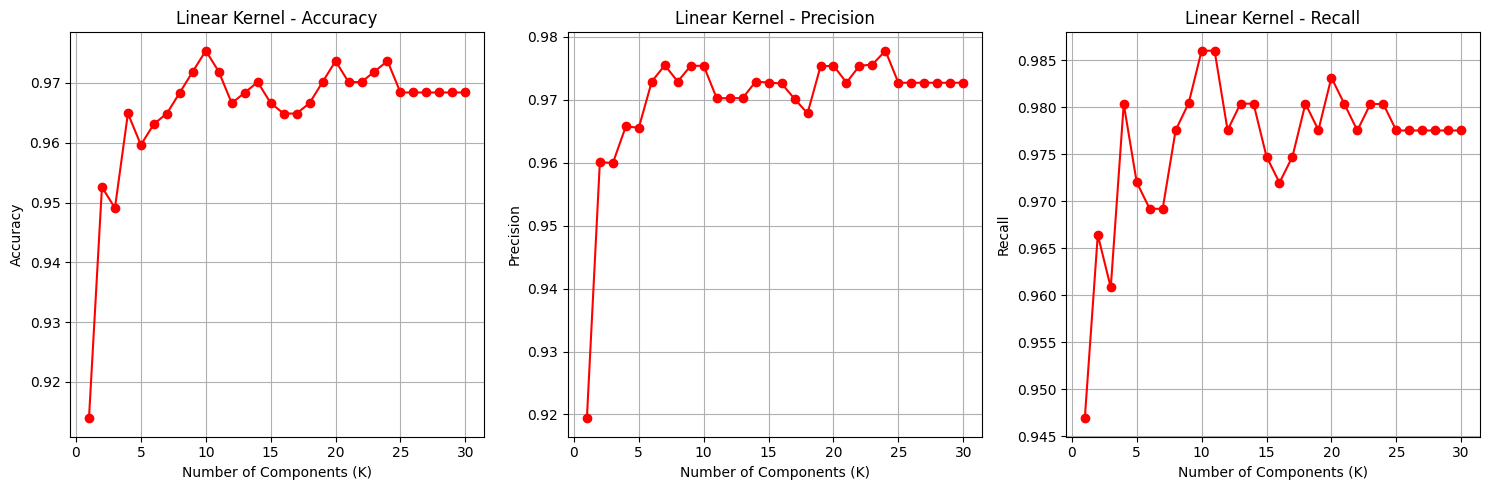

Kernel: linear, Best Accuracy: 0.9754, Optimal Components: 10


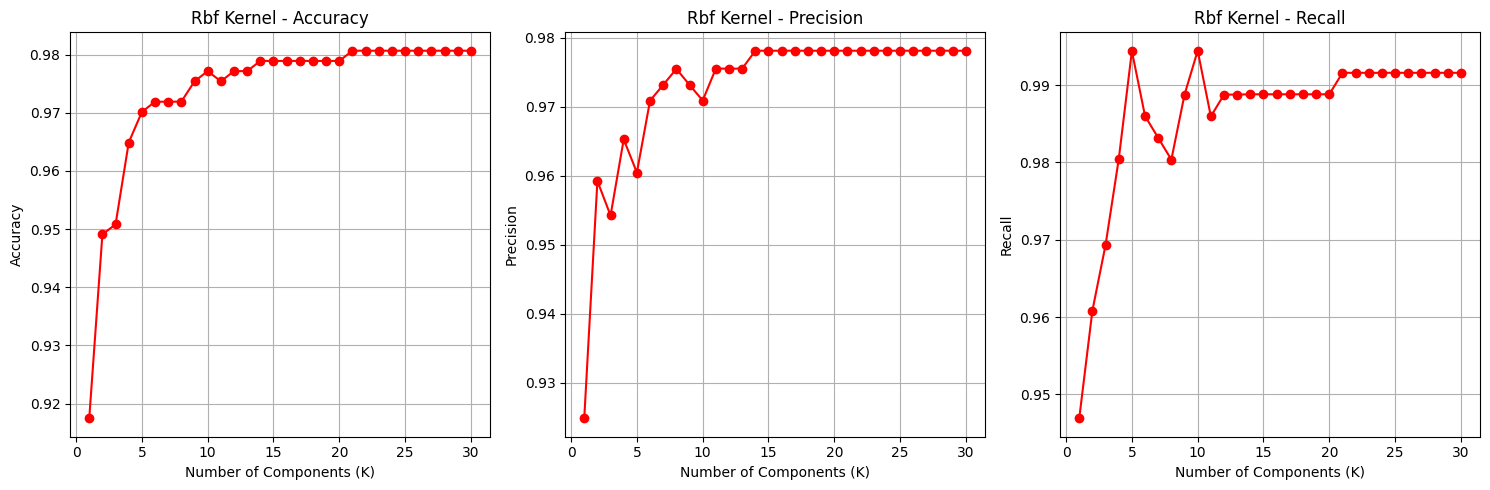

Kernel: rbf, Best Accuracy: 0.9807, Optimal Components: 21


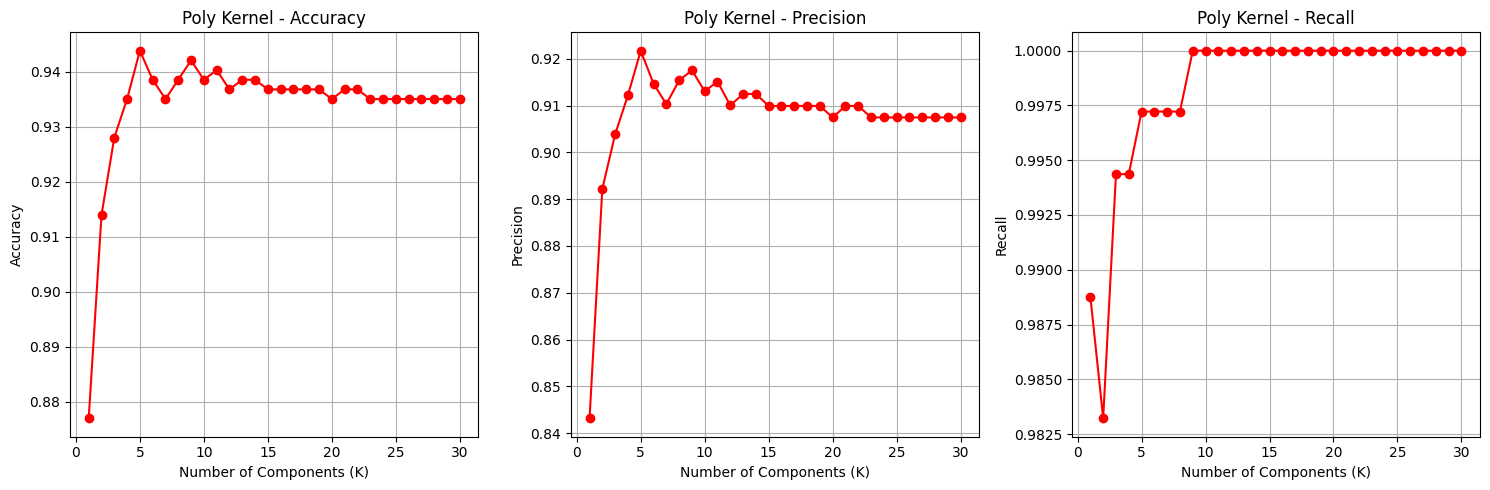

Kernel: poly, Best Accuracy: 0.9438, Optimal Components: 5


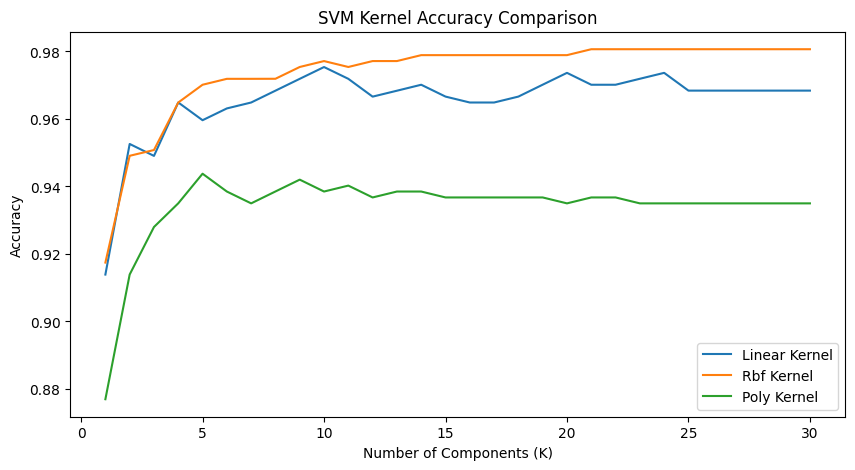

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

#database
cancer_data = load_breast_cancer()
df_cancer = pd.DataFrame(cancer_data.data, columns = cancer_data.feature_names)
df_cancer['target'] = cancer_data.target

X_cancer = df_cancer.drop('target', axis=1).values
y_cancer = df_cancer['target']

scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

#plot #how much info is retained
pca_full = PCA().fit(X_cancer_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', color='red')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

def perform_svm_pca_cv(features, labels, kernel, component_range, C=3, gamma='scale', param_grid=None):
    """
    Args:
    features: input data matix
    labels: target labels
    kernel: SVM kernel type
    component_range: range of PCA
    C: SVM regularization parameter
    gamma: SVM kernel coefficient
    param_grid: param_grid for GridSearchCV

  Returns:
    dict: metrcis for each component
    float: best accuracy achieved
    int: optimal
    """
    metrics_data = {'accuracy': [], 'precision': [], 'recall': []}
    best_accuracy, optimal_components = 0, None

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for k in component_range:
        pca = PCA(n_components=k)
        X_reduced = pca.fit_transform(features)

        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []

        if param_grid and kernel == 'rbf':
            svm = SVC(kernel=kernel)
            grid_search = GridSearchCV(svm, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_reduced, labels)
            best_params = grid_search.best_params_
            svm_model = SVC(kernel=kernel, **best_params)
        else:
            svm_model = SVC(kernel=kernel, C=C, gamma=gamma)

        for train_index, test_index in skf.split(X_reduced, labels):
            X_train, X_test = X_reduced[train_index], X_reduced[test_index]
            y_train, y_test = labels[train_index], labels[test_index]

            svm_model.fit(X_train, y_train)
            predictions = svm_model.predict(X_test)

            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            fold_accuracies.append(acc)
            fold_precisions.append(prec)
            fold_recalls.append(rec)

        avg_acc = np.mean(fold_accuracies)
        avg_prec = np.mean(fold_precisions)
        avg_rec = np.mean(fold_recalls)

        metrics_data['accuracy'].append(avg_acc)
        metrics_data['precision'].append(avg_prec)
        metrics_data['recall'].append(avg_rec)

        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            optimal_components = k

    return metrics_data, best_accuracy, optimal_components

def plot_svm_metrics(metrics, component_range, kernel_type):
    """
    Args:
        metrics: data for plotting.
        component_range: PCA component range.
        kernel_type: SVM kernel
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for idx, metric in enumerate(['accuracy', 'precision', 'recall']):
        axes[idx].plot(component_range, metrics[metric], marker='o', color='red')
        axes[idx].set_title(f'{kernel_type.capitalize()} Kernel - {metric.capitalize()}')
        axes[idx].set_xlabel('Number of Components (K)')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

component_range = list(range(1, 31))
kernels = ['linear', 'rbf', 'poly']

param_grid_rbf = {'C': [0.1, 1, 10, 100],'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}

for kernel in kernels:
    if kernel == 'rbf':
        metrics, best_acc, best_k = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range, param_grid=param_grid_rbf)
    else:
        metrics, best_acc, best_k = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range)

    plot_svm_metrics(metrics, component_range, kernel)
    print(f"Kernel: {kernel}, Best Accuracy: {best_acc:.4f}, Optimal Components: {best_k}")

plt.figure(figsize=(10, 5))
for kernel in kernels:
    if kernel == 'rbf':
        metrics, _, _ = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range, param_grid=param_grid_rbf)
    else:
        metrics, _, _ = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range)
    plt.plot(component_range, metrics['accuracy'], label=f'{kernel.capitalize()} Kernel')

plt.xlabel('Number of Components (K)')
plt.ylabel('Accuracy')
plt.title('SVM Kernel Accuracy Comparison')
plt.legend()
plt.show()


Ridge Regression MSE: 967304128476.79
SVR RBF Kernel MSE: 2943512986923.79
SVR Linear Kernel MSE: 1798280910506.73
SVR Polynomial Kernel MSE: 2959410847126.26
Optimal number of PCA components for RBF kernel: 1, MSE: 2844076693503.25


/tmp/ipykernel_5753/4234416372.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  housing_df[binary_columns] = housing_df[binary_columns].replace({'yes': 1, 'no': 0})


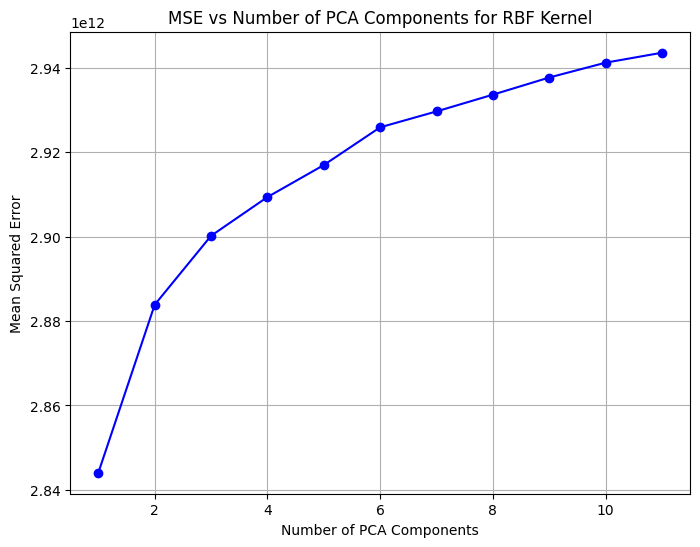

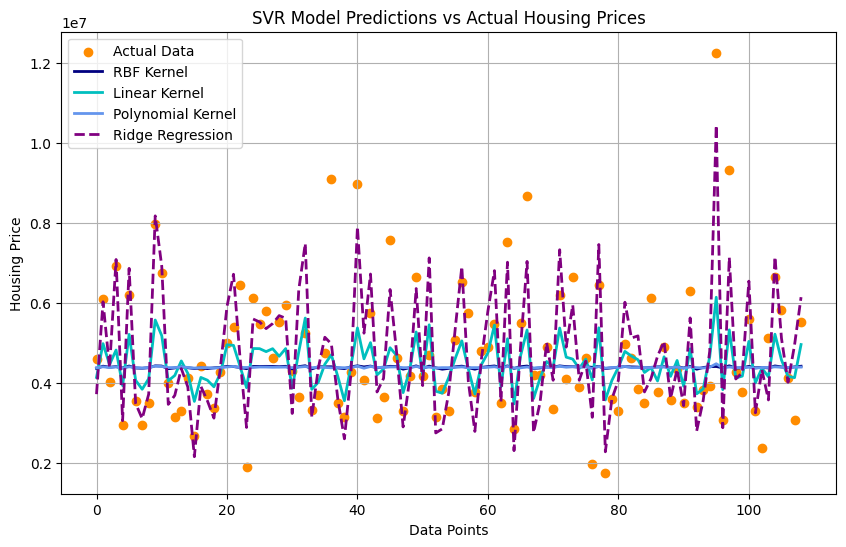

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Load dataset
housing_df = pd.read_csv('assets/Housing.csv')
binary_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
housing_df[binary_columns] = housing_df[binary_columns].replace({'yes': 1, 'no': 0})

# Define input features and target
labels = ["area", "bedrooms", "bathrooms", "stories", "mainroad", 
           "guestroom", "basement", "hotwaterheating", "airconditioning", 
           "parking", "prefarea"]
X = housing_df[labels]
y = housing_df['price']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# #############################################################################
# 1. Fit SVR models with different kernels
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

# Fit models
y_rbf_pred = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin_pred = svr_lin.fit(X_train, y_train).predict(X_test)
y_poly_pred = svr_poly.fit(X_train, y_train).predict(X_test)

# #############################################################################
# 2. Compare with linear regression (Ridge Regression as a regularized model)
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_ridge_pred)

# Calculate MSE for each SVR model
mse_rbf = mean_squared_error(y_test, y_rbf_pred)
mse_lin = mean_squared_error(y_test, y_lin_pred)
mse_poly = mean_squared_error(y_test, y_poly_pred)

print(f"Ridge Regression MSE: {ridge_mse:.2f}")
print(f"SVR RBF Kernel MSE: {mse_rbf:.2f}")
print(f"SVR Linear Kernel MSE: {mse_lin:.2f}")
print(f"SVR Polynomial Kernel MSE: {mse_poly:.2f}")

# #############################################################################
# 3. Use PCA and identify optimal number of components (K) for highest accuracy
component_range = range(1, 12)
mse_scores = []
optimal_components = 0
best_mse = float("inf")

for k in component_range:
    # Apply PCA
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train and evaluate RBF SVR on reduced data
    svr_rbf_pca = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf_pca.fit(X_train_pca, y_train)
    y_rbf_pca_pred = svr_rbf_pca.predict(X_test_pca)
    mse = mean_squared_error(y_test, y_rbf_pca_pred)
    mse_scores.append(mse)
    
    # Track the best MSE and optimal number of components
    if mse < best_mse:
        best_mse = mse
        optimal_components = k

print(f"Optimal number of PCA components for RBF kernel: {optimal_components}, MSE: {best_mse:.2f}")

# Plot MSE vs Number of Components for RBF Kernel
plt.figure(figsize=(8, 6))
plt.plot(component_range, mse_scores, marker='o', color='blue')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of PCA Components for RBF Kernel')
plt.grid(True)
plt.show()

# #############################################################################
# 4. Visualization of SVR model predictions
plt.figure(figsize=(10, 6))
lw = 2
plt.scatter(range(len(y_test)), y_test, color='darkorange', label='Actual Data')
plt.plot(range(len(y_test)), y_rbf_pred, color='navy', lw=lw, label='RBF Kernel')
plt.plot(range(len(y_test)), y_lin_pred, color='c', lw=lw, label='Linear Kernel')
plt.plot(range(len(y_test)), y_poly_pred, color='cornflowerblue', lw=lw, label='Polynomial Kernel')
plt.plot(range(len(y_test)), y_ridge_pred, color='purple', lw=lw, linestyle='--', label='Ridge Regression')
plt.xlabel('Data Points')
plt.ylabel('Housing Price')
plt.title('SVR Model Predictions vs Actual Housing Prices')
plt.legend()
plt.grid(True)
plt.show()
